In [1]:
#载入必要的包
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils                         #数据处理，归一化用到的
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences   #用于填充句子长度
from keras.layers import LSTM, Dense, Embedding, Dropout  #Dense全连接层；Embedding自嵌入，方便模型输入；Dropout防止模型过拟合
from sklearn.model_selection import train_test_split

In [2]:
# 设置matplotlib绘图时的字体
from matplotlib import font_manager
my_font=font_manager.FontProperties(fname="/Library/Fonts/Songti.ttc")

In [3]:
# In[ ]: 读入数据
data = pd.read_csv("data.csv")
#查看数据
print(data.head())

                                          evaluation label
0                                    用了一段时间，感觉还不错，可以    正面
1  电视非常好，已经是家里的第二台了。第一天下单，第二天就到本地了，可是物流的人说车坏了，一直催...    正面
2                  电视比想象中的大好多，画面也很清晰，系统很智能，更多功能还在摸索中    正面
3                                                 不错    正面
4     用了这么多天了，感觉还不错。夏普的牌子还是比较可靠。希望以后比较耐用，现在是考量质量的时候。    正面


In [4]:
# 查看有多少种评价
print(data.groupby("label")["label"].count())  #["label"]统计label有多少

label
正面    1908
负面    2375
Name: label, dtype: int64


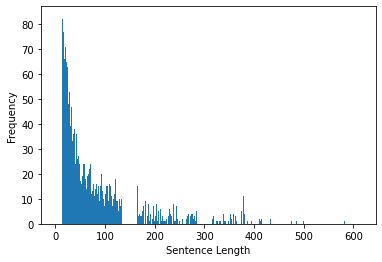

In [5]:
# 统计句子长度及长度出现的频数
data["length"] = data["evaluation"].apply(lambda x:len(x))
len_data = data.groupby("length").count()
#print(len_data)
length = len_data.index.tolist()  #把句子长度转换为列表
freq = len_data["evaluation"].tolist() #把计数转换为列表
plt.bar(length,freq)
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()

In [6]:
# 标签及词汇表
labels, vocabulary = list(data["label"].unique()),list(data["evaluation"].unique())
#构造字符级别的特征
#print(labels,vocabulary)
string = ""
for word in vocabulary:
    string += word
vocabulary = set(string)
print(vocabulary)

{'闷', '崩', '兆', '题', '强', '支', '旁', '贝', '）', '恨', '摆', '永', '帅', '组', '戚', '晰', '漆', '代', '鮮', '恢', '水', '混', '官', '防', '星', '欧', '车', '平', '溃', '对', '位', 'm', '几', '徐', '符', '干', '阔', '起', '拥', '吸', '恶', '餐', ':', '贺', '家', '延', '丈', '迹', '買', '追', '找', '演', '告', '作', '锥', '蛮', '播', '汉', '徊', '辙', '金', '枝', '量', '企', '仁', '钝', '6', '肉', '环', '揉', '诫', '溜', '办', '常', '障', '双', '设', '币', '捌', '慧', '额', '栓', '扑', '涨', '紫', '挪', '读', '使', '機', '立', '层', '尾', '材', '暂', '算', '第', '丧', '洋', '绝', '9', '歧', '合', '及', '瑰', '桃', '军', '植', '辫', '县', 'S', '渠', '龟', '升', '触', '续', '璃', '泄', '伙', '造', '险', '尴', '喽', '臭', '已', '住', 'L', '耍', '曾', '财', '_', '扔', '骗', '极', '完', '开', '迟', '挖', '砸', '”', '轮', '异', '前', '挂', '凶', '雇', '赢', '拍', '捏', '民', '趣', '优', '查', '怎', '仿', '奶', 'G', '素', '＋', '整', '技', '点', '酷', '峰', '厅', '愿', '圾', '龄', '嘟', '醒', '在', '澡', '拉', '况', '齐', '２', '集', '啊', '勒', '鸡', '焦', '意', '云', '脾', '艳', '间', '颇', '半', '会', '录', '產', '炮', '黑', 'M', '经', '悦', '糊', '奔', '太', '恳', '待',

In [7]:
print(len(vocabulary))

2154


In [8]:
# 制作字典列表，用在人机交互
word_dictionary = {word:i+1 for i, word in enumerate(vocabulary)}
inverse_word_dictionary = {i + 1: word for i, word in enumerate(vocabulary)}
print(inverse_word_dictionary)

{1: '闷', 2: '崩', 3: '兆', 4: '题', 5: '强', 6: '支', 7: '旁', 8: '贝', 9: '）', 10: '恨', 11: '摆', 12: '永', 13: '帅', 14: '组', 15: '戚', 16: '晰', 17: '漆', 18: '代', 19: '鮮', 20: '恢', 21: '水', 22: '混', 23: '官', 24: '防', 25: '星', 26: '欧', 27: '车', 28: '平', 29: '溃', 30: '对', 31: '位', 32: 'm', 33: '几', 34: '徐', 35: '符', 36: '干', 37: '阔', 38: '起', 39: '拥', 40: '吸', 41: '恶', 42: '餐', 43: ':', 44: '贺', 45: '家', 46: '延', 47: '丈', 48: '迹', 49: '買', 50: '追', 51: '找', 52: '演', 53: '告', 54: '作', 55: '锥', 56: '蛮', 57: '播', 58: '汉', 59: '徊', 60: '辙', 61: '金', 62: '枝', 63: '量', 64: '企', 65: '仁', 66: '钝', 67: '6', 68: '肉', 69: '环', 70: '揉', 71: '诫', 72: '溜', 73: '办', 74: '常', 75: '障', 76: '双', 77: '设', 78: '币', 79: '捌', 80: '慧', 81: '额', 82: '栓', 83: '扑', 84: '涨', 85: '紫', 86: '挪', 87: '读', 88: '使', 89: '機', 90: '立', 91: '层', 92: '尾', 93: '材', 94: '暂', 95: '算', 96: '第', 97: '丧', 98: '洋', 99: '绝', 100: '9', 101: '歧', 102: '合', 103: '及', 104: '瑰', 105: '桃', 106: '军', 107: '植', 108: '辫', 109: '县', 110: 'S', 111: '渠

In [9]:
# 查看词汇表大小和标签类别数量
label_dictionary = {label:i for i, label in enumerate(labels)}
output_dictionary = {i:label for i, label in enumerate(labels)}
print(label_dictionary)
print(output_dictionary)

{'正面': 0, '负面': 1}
{0: '正面', 1: '负面'}


In [10]:
vocab_size = len(word_dictionary.keys())
label_size = len(label_dictionary.keys())
print(vocab_size)
print(label_size)

2154
2


In [11]:
#制作训练输入和训练标签
#对于训练输入要进行序列填充，按input_shape填充，长度不足的按0补充
x = [[word_dictionary[word] for word in sent] for sent in data["evaluation"]] #相当于把每个句子编码化
x = pad_sequences(maxlen = 180, truncating="pre", sequences = x, padding="post",value = 0) #如果句子超过180，就截取pre前面的部分；不够180填充post后面的部分，填充值为0
print(x.shape)
print(x)  #输入4283*180

(4283, 180)
[[1955 1455  240 ...    0    0    0]
 [ 351  652 1314 ...    0    0    0]
 [ 351  652 1555 ...    0    0    0]
 ...
 [ 240 1119  939 ...    0    0    0]
 [ 930  351  652 ...    0    0    0]
 [ 240 1938 1938 ...    0    0    0]]


In [12]:
#对于标签进行ONE-HOT-CODING
y = [[label_dictionary[sent]]for sent in data["label"]]
#print(y)
y = [np_utils.to_categorical(label, num_classes = label_size) for label in y]  #进行独热编码处理
#print(y)
y = np.array([list(_[0]) for _ in y])
print(y)
print(y.shape) #输出

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
(4283, 2)


In [13]:
# 拆分训练集和测试集
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.1) #train_test_split是sklearn中输入的，直接拆分训练集和测试集

In [14]:
#搭建模型
model = Sequential()
model.add(Embedding(input_dim = vocab_size + 1, output_dim = 20, input_length = 180,mask_zero=True)) 
#如果搭建一个2000多长度的one-hot-coding不好：1、训练上很麻烦；2、词汇之间的关联性不好，不利于模型得到一个比较好的表现
#这里把它用一个embedding词嵌入，把它压缩成一个矩阵，例如a这个词[[0.1 0.2 ... 0.01], ... ]根据重要性。总之是吧2000多长的one-hot-coding压缩成一个20个长度的向量output_dim = 20。目的是把输入转换成相应的矩阵形式，方便后面层来训练
#input_dim：大或等于0的整数，字典长度，即输入数据最大下标+1
#output_dim：大于0的整数，代表全连接嵌入的维度
#input_length：当输入序列的长度固定时，该值为其长度。如果要在该层后接Flatten层，然后接Dense层，则必须指定该参数，否则Dense层的输出维度无法自动推断。
#mask_zero：布尔值，确定是否将输入中的‘0’看作是应该被忽略的‘填充’（padding）值，该参数在使用递归层处理变长输入时有用。设置为True的话，模型中后续的层必须都支持masking，否则会抛出异常。如果该值为True，则下标0在字典中不可用，input_dim应设置为|vocabulary| + 2。
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(label_size,activation = "softmax"))  #最后是全连接层，这里输出大小label_size=2
##加上全连接层，输出大小是label_size这里等于2。 就是输入是180长度，输出是1个值，准确说是onehotcoding，many to 1的格式.[0 1]第一个数值的大小是好评，第二个是差评，两个数值之和是1
model.summary()
#相比于卷积神经网络，文字识别的层很浅并不深，也能达到不错的效果，这也是循环神经网络比较厉害的地方

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 180, 20)           43100     
                                                                 
 lstm (LSTM)                 (None, 100)               48400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 91,702
Trainable params: 91,702
Non-trainable params: 0
_________________________________________________________________


In [15]:
#编译模型
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [16]:
#训练模型
model.fit(train_x, train_y, epochs = 5, batch_size = 32, validation_data = (test_x, test_y))

Epoch 1/5
121/121 [==============================] - 8s 49ms/step - loss: 0.4562 - accuracy: 0.7987 - val_loss: 0.2293 - val_accuracy: 0.9347
Epoch 2/5
121/121 [==============================] - 5s 42ms/step - loss: 0.2246 - accuracy: 0.9305 - val_loss: 0.2161 - val_accuracy: 0.9184
Epoch 3/5
121/121 [==============================] - 5s 40ms/step - loss: 0.1832 - accuracy: 0.9437 - val_loss: 0.1935 - val_accuracy: 0.9301
Epoch 4/5
121/121 [==============================] - 5s 39ms/step - loss: 0.1462 - accuracy: 0.9551 - val_loss: 0.2141 - val_accuracy: 0.9138
Epoch 5/5
121/121 [==============================] - 5s 39ms/step - loss: 0.1434 - accuracy: 0.9564 - val_loss: 0.2253 - val_accuracy: 0.9301


In [19]:
#测试新的评论
sent = "真棒"
temp_x = [[word_dictionary[word] for word in sent]]
temp_x = pad_sequences(maxlen = 180, sequences = temp_x, padding = "post", value = 0)
print(temp_x)
# 模型预测
y_predict = model.predict(temp_x)
print(y_predict)
print(output_dictionary)
print(output_dictionary[np.argmax(y_predict)])   #np.argmax()是numpy中获取array的某一个维度中数值最大的那个元素的索引

[[ 907 1811    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
[[0.94262177 0.05737821]]
{0: '正面', 1: '负面'}
正面
